In [19]:
%matplotlib  inline
import pandas as pd
from datetime import datetime
import quandl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from scipy import poly1d
from pykalman import KalmanFilter

In [20]:
# All helper functions go here
def supres(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """
    from scipy.signal import savgol_filter as smooth

    #converting n to a nearest even number
    if n%2 != 0:
        n += 1
    ltp=np.ravel(ltp)
    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n+1), 3) 

    #taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
 
    resistance = []
    support = []
    
    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i+n)]
        first = arr_sl[:int((n/2))] #first half
        last = arr_sl[int((n/2)):] #second half
        
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        #local maxima detection
        if (r_1 == int((n/2))) and (r_2 == int((n/2))): 
            resistance.append(ltp[i+int(((n/2))-1)])

        #local minima detection
        if (s_1 == int((n/2))) and (s_2 == int((n/2))): 
            support.append(ltp[i+int(((n/2))-1)])

    return support, resistance
import scipy.ndimage as ndimage

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=1):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, max_distance):
    """Group extremes by cluster based on absolute price distance."""
    # if Dataframe take first column
    if isinstance(signify,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(signify,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= max_distance:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def logReturns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan
    
def calc_extreme_distance(series,sup_array,res_array):
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value < nearest_sup:
            dist_s.append(np.nan)
        elif curr_value > nearest_res:
            dist_r.append(np.nan)
        else:
            dist_s.append(curr_value-nearest_sup)
            dist_r.append(nearest_res-curr_value)
    if dist_s and dist_r:
        return dist_s,dist_r
    


In [21]:
quandl.ApiConfig.api_key = "xoemPs9s3Dtwf3aQxQ-3"
start="2010-01-02"

INTC = pdr.get_data_yahoo("INTC",start=start)
MSFT = pdr.get_data_yahoo("MSFT",start=start)
AMZN = pdr.get_data_yahoo("AMZN",start=start)
NVDA = pdr.get_data_yahoo("NVDA",start=start)
GOOG = pdr.get_data_yahoo("GOOG",start=start)
NFLX = pdr.get_data_yahoo("NFLX",start=start)
# macro data 
EUROSTOXX50 = pdr.get_data_yahoo("FEZ",start=start)
SNP500 = pdr.get_data_yahoo("^GSPC",start=start)
CONS_DESCRETE = pdr.get_data_yahoo("XLY",start=start)
SNP_TECH = pdr.get_data_yahoo("XLK",start=start)
NASDAQ_COMP = pdr.get_data_yahoo("^IXIC",start=start)
VIX = pdr.get_data_yahoo("^VIX",start=start)

# FRED & Treasury
yieldr = quandl.get("USTREASURY/REALYIELD", start_date=start, verify=False)
consumer_price_index = quandl.get("FRED/CPIAUCSL", start_date=start, verify=False)
gdpc = quandl.get("FRED/GDPC1", start_date=start, verify=False)
tnote_y10 = quandl.get("FRED/DGS10", start_date=start, verify=False)
financial_stress = quandl.get("FRED/STLFSI", start_date=start, verify=False)
effective_federal_fund_rate = quandl.get("FRED/FEDFUNDS", start_date=start, verify=False)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


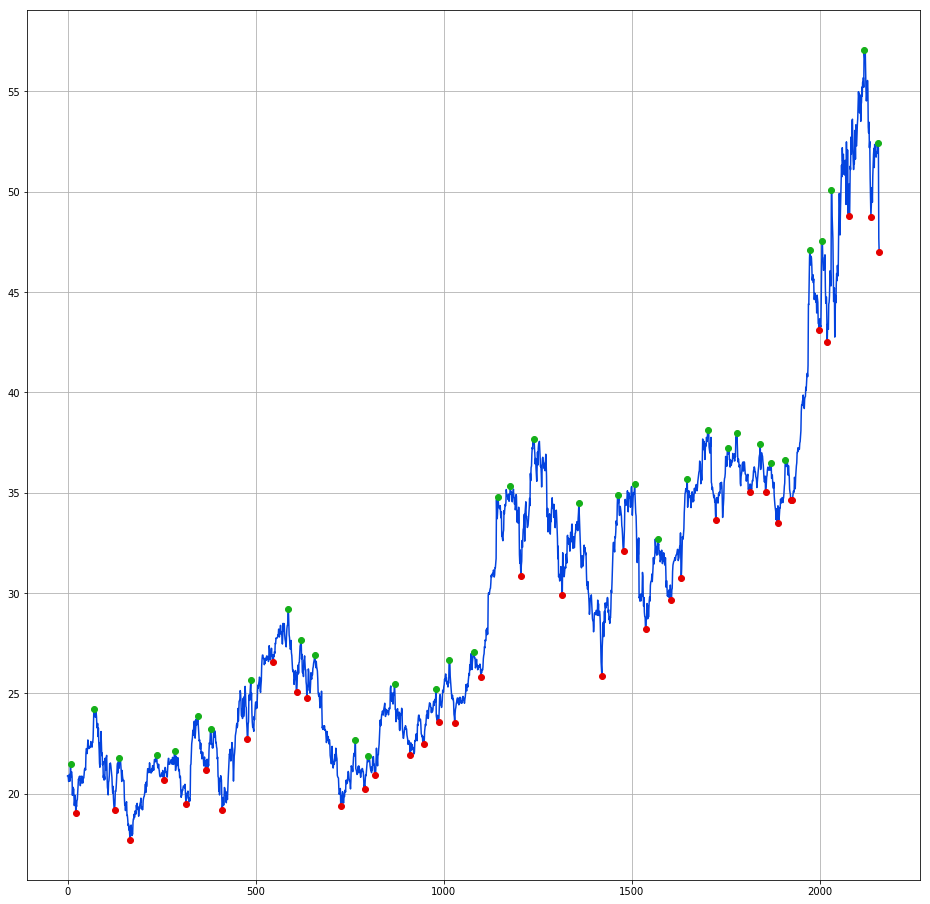

In [22]:
# Plots
cl=np.ravel(INTC[['Close']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 20
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

len of x is: 36


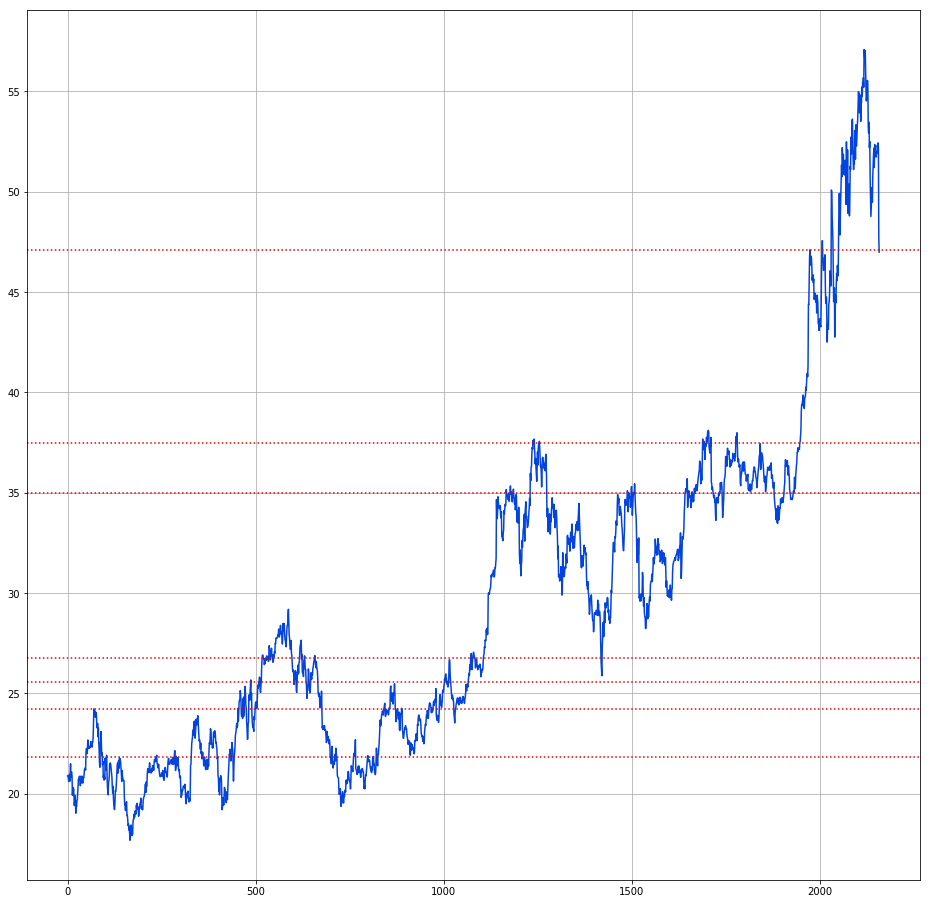

In [23]:
# Show horizontal resistance levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)])
signify = extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_res = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

len of x is: 37


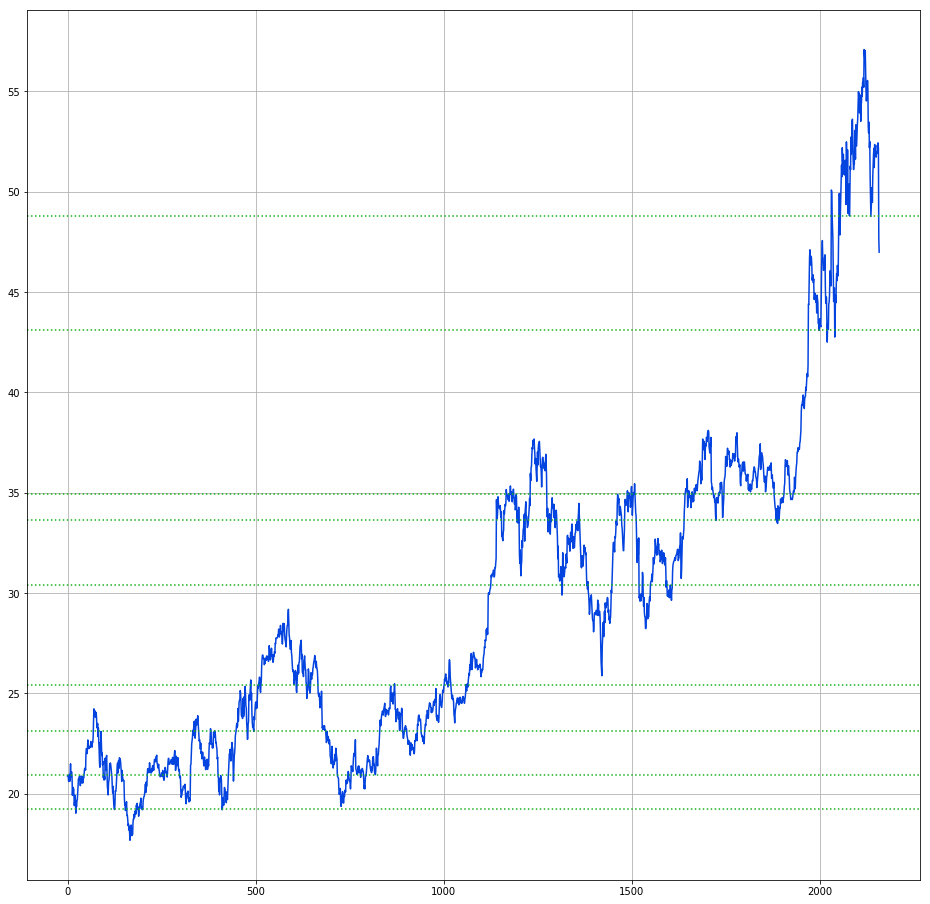

In [24]:
# Show horizontal support levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)])
signify =extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_sup = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

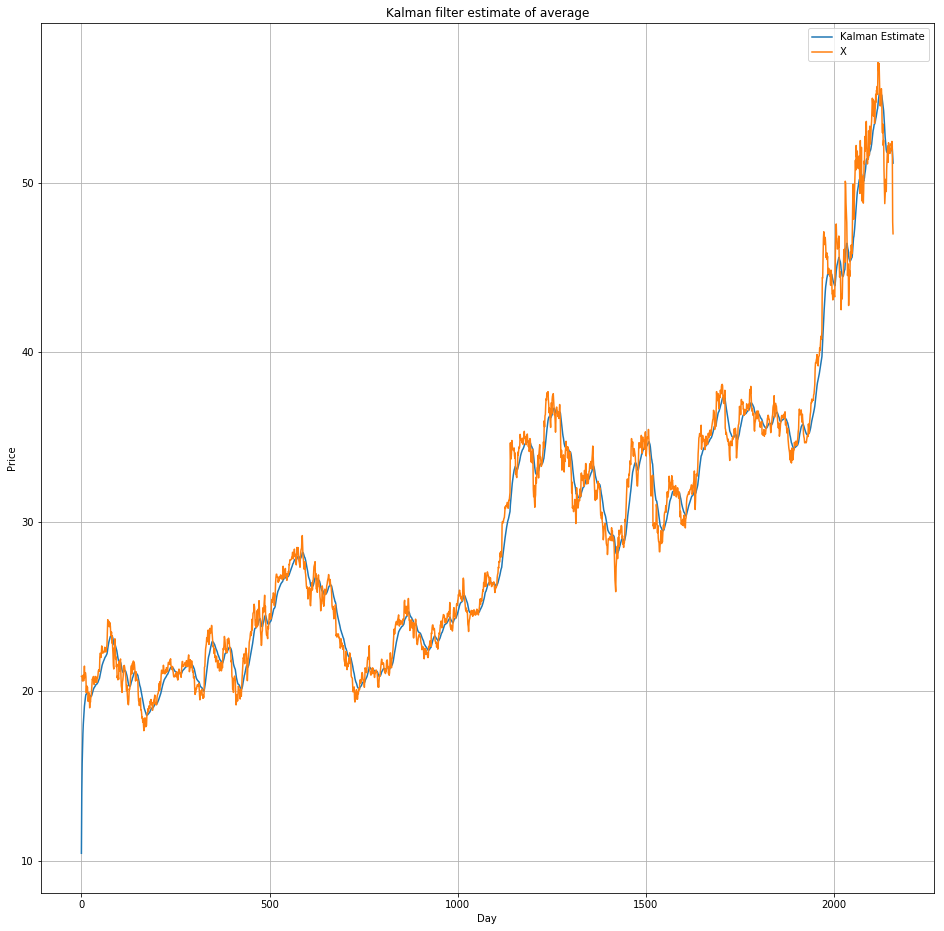

In [25]:
x = INTC['Close'].values
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
state_means, _ = kf.filter(x)
state_means = state_means.flatten()

plt.rc("figure",figsize=(16,16))
# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X'])
plt.xlabel('Day')
plt.ylabel('Price');
plt.grid(True)
state_means = pd.DataFrame(data=state_means,index=INTC['Close'].index)
state_means.columns = ['KF']

In [26]:
result = pd.concat([INTC, MSFT[['Close']].rename(columns={'Close': 'MSFT'})], axis=1)
result = pd.concat([result, state_means.rename(columns={'KF': 'KF_mean'})], axis=1)
result = pd.concat([result, AMZN[['Close']].rename(columns={'Close': 'AMZN'})], axis=1)
result = pd.concat([result, NVDA[['Close']].rename(columns={'Close': 'NVDA'})], axis=1)
result = pd.concat([result, GOOG[['Close']].rename(columns={'Close': 'GOOG'})], axis=1)
result = pd.concat([result, NFLX[['Close']].rename(columns={'Close': 'NFLX'})], axis=1)
result = pd.concat([result, EUROSTOXX50[['Close']].rename(columns={'Close': 'EUROSTOXX50'})], axis=1)
result = pd.concat([result, SNP500[['Close']].rename(columns={'Close': 'SNP500'})], axis=1)
result = pd.concat([result, CONS_DESCRETE[['Close']].rename(columns={'Close': 'CONS_DESCRETE'})], axis=1)
result = pd.concat([result, SNP_TECH[['Close']].rename(columns={'Close': 'SNP_TECH'})], axis=1)
result = pd.concat([result, NASDAQ_COMP[['Close']].rename(columns={'Close': 'NASDAQ_COMP'})], axis=1)
result = pd.concat([result, VIX[['Close']].rename(columns={'Close': 'VIX'})], axis=1)

# distance to next extremes
[sup,res] = calc_extreme_distance(cl,extremes_sup,extremes_res) 
sr = pd.DataFrame(data=np.transpose([sup,res]),index=INTC.index )
sr.columns = ['support_distance', 'resistance_distance']
result = pd.concat([result, sr], axis=1)

# fred
result = pd.concat([result, yieldr[['5 YR']].rename(columns={'5 YR': 'yield_5y'})], axis=1)
result = pd.concat([result, tnote_y10.rename(columns={'Value': 'Tnote_10y'})], axis=1)

result = result.drop('Adj Close', axis=1)
result['Weekday'] = result.index.weekday
result['Daymonth'] = result.index.day
result['Month'] = result.index.month
result['Weakyear'] = result.index.weekofyear
#result = result.dropna()

In [27]:
result[['yield_5y']] = result[['yield_5y']].replace(0, 0.00000001)
result[['yield_5y']] = result[['yield_5y']]+10
result[['support_distance']] = result[['support_distance']].replace(0, 0.00000001)
result[['resistance_distance']] = result[['resistance_distance']].replace(0, 0.00000001)
logRet = result[['High','Low','Close','MSFT','AMZN','NVDA','GOOG','NFLX','EUROSTOXX50','SNP500',
                 'CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','VIX','yield_5y','Tnote_10y']].apply(logReturns)

logRet.columns = [str(col) + '_logReturns' for col in logRet.columns]

result = pd.concat([result, logRet], axis=1)

In [28]:
momentum  =  result[['Close']].diff(periods=5)
momentum  =  momentum[~np.isnan(momentum)]
result['TradingRange'] = result["High"]-result["Low"]
result['OBV'] = on_balance_volume(result["Close"], result["Volume"])
result['TSI'] = tsi(result["Close"])
result['ATR'] = average_true_range(result["High"],result["Low"],result["Close"])
result['HighestHigh'] = result['High'].rolling(window=21,center=False,min_periods=1).max()
result['LowestLow'] = result['Low'].rolling(window=21,center=False,min_periods=1).min()

result['Volume'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['Volume']].values)
result['Volume_Scaled'] = scaler.transform(result[['Volume']].values)

result.head(3)

,Open,High,Low,Close,Volume,MSFT,KF_mean,AMZN,NVDA,GOOG,NFLX,EUROSTOXX50,SNP500,CONS_DESCRETE,SNP_TECH,NASDAQ_COMP,VIX,support_distance,resistance_distance,yield_5y,Tnote_10y,Weekday,Daymonth,Month,Weakyear,High_logReturns,Low_logReturns,Close_logReturns,MSFT_logReturns,AMZN_logReturns,NVDA_logReturns,GOOG_logReturns,NFLX_logReturns,EUROSTOXX50_logReturns,SNP500_logReturns,CONS_DESCRETE_logReturns,SNP_TECH_logReturns,NASDAQ_COMP_logReturns,VIX_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,TradingRange,OBV,TSI,ATR,HighestHigh,LowestLow,Volume_Scaled
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.790001,21.030001,20.73,20.879999,47800900.0,30.950001,10.439999,133.899994,18.490000,311.349976,7.640000,42.900002,1132.989990,30.000000,23.27,2308.419922,20.040001,1.654998,0.947501,10.52,3.85,0,4,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.300001,0.0,0.0,0.300001,21.030001,20.73,0.240202
2010-01-05,20.940001,20.990000,20.60,20.870001,52357700.0,30.959999,13.962715,134.690002,18.760000,309.978882,7.358572,42.700001,1136.520020,30.110001,23.24,2308.709961,19.350000,1.645001,0.957499,10.44,3.77,1,5,1,1,-0.001904,-0.006291,-0.000479,0.000323,0.005883,0.014497,-0.004413,-0.037532,-0.004673,0.003111,0.003660,-0.001290,0.000126,-0.035038,-0.007634,-0.020998,0.390000,-52357700.0,-100.0,0.346552,21.030001,20.60,0.263101
2010-01-06,20.809999,20.930000,20.67,20.799999,40037400.0,30.770000,15.726883,132.250000,18.879999,302.164703,7.617143,42.639999,1137.140015,30.150000,22.98,2301.090088,19.160000,1.574998,1.027501,10.44,3.85,2,6,1,1,-0.002863,0.003392,-0.003360,-0.006156,-0.018282,0.006376,-0.025532,0.034535,-0.001406,0.000545,0.001328,-0.011251,-0.003306,-0.009868,0.000000,0.020998,0.260000,-40037400.0,-100.0,0.315690,21.030001,20.60,0.201190


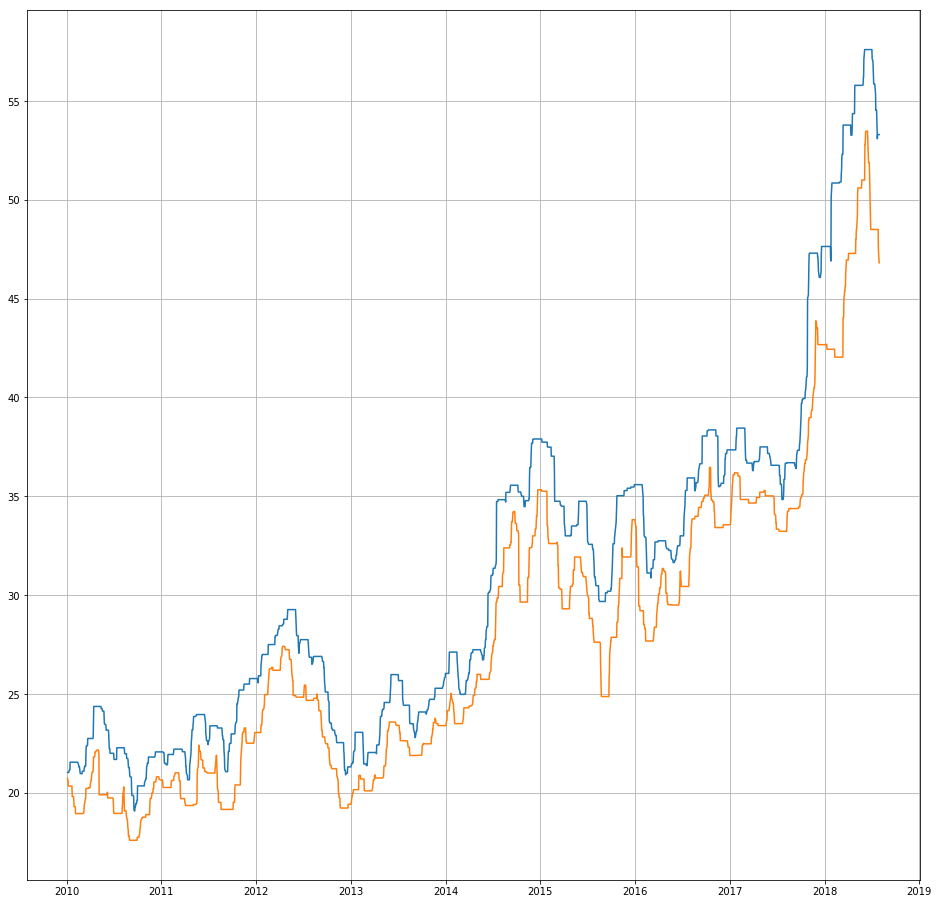

In [29]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(result['HighestHigh'])
plt.plot(result['LowestLow'])
plt.grid(True)

In [30]:
scaler = prep.MaxAbsScaler().fit(result[['ATR']].values)
result['ATR_Scaled'] = scaler.transform(result[['ATR']].values)

scaler = prep.MaxAbsScaler().fit(result[['TSI']].values)
result['TSI_Scaled'] = scaler.transform(result[['TSI']].values)

scaler = prep.MaxAbsScaler().fit(result[['OBV']].values)
result['OBV_Scaled'] = scaler.transform(result[['OBV']].values)

result['TradingRange'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['TradingRange']].values)
result['TradingRange_Scaled'] = scaler.transform(result[['TradingRange']].values)

scaler = prep.MaxAbsScaler().fit(result[['HighestHigh']].values)
result['HighestHigh_Scaled'] = scaler.transform(result[['HighestHigh']].values)

scaler = prep.MaxAbsScaler().fit(result[['LowestLow']].values)
result['LowestLow_Scaled'] = scaler.transform(result[['LowestLow']].values)

result['KF_mean'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['KF_mean']].values)
result['KFMean_Scaled'] = scaler.transform(result[['KF_mean']].values)

result['support_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['support_distance']].values)
result['support_distance_Scaled'] = scaler.transform(result[['support_distance']].values)

result['resistance_distance'].fillna(method ='ffill', inplace=True)
scaler = prep.MaxAbsScaler().fit(result[['resistance_distance']].values)
result['resistance_distance_Scaled'] = scaler.transform(result[['resistance_distance']].values)

result = result.iloc[5:]

In [31]:
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(-1,0)
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(0,0.00000001)
#result = result.drop('TSI', axis=1)
#result = result.drop('ATR', axis=1)
#result = result.drop('OBV', axis=1)
#result = result.drop('TradingRange', axis=1)
#result = result.drop('HighestHigh', axis=1)
#result = result.drop('LowestLow', axis=1)

In [32]:
train_data = result.drop(['Open', 'High','Low','Close','Volume','MSFT','AMZN','NVDA','GOOG','NFLX'
                          ,'EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y'
                          ,'Tnote_10y','support_distance','resistance_distance'], axis=1)

In [33]:
pd.set_option('display.max_columns', 100)
train_data.head(11)

,KF_mean,VIX,Weekday,Daymonth,Month,Weakyear,High_logReturns,Low_logReturns,Close_logReturns,MSFT_logReturns,AMZN_logReturns,NVDA_logReturns,GOOG_logReturns,NFLX_logReturns,EUROSTOXX50_logReturns,SNP500_logReturns,CONS_DESCRETE_logReturns,SNP_TECH_logReturns,NASDAQ_COMP_logReturns,VIX_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,TradingRange,OBV,TSI,ATR,HighestHigh,LowestLow,Volume_Scaled,ATR_Scaled,TSI_Scaled,OBV_Scaled,TradingRange_Scaled,HighestHigh_Scaled,LowestLow_Scaled,KFMean_Scaled,support_distance_Scaled,resistance_distance_Scaled
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-11,18.049804,17.549999,0,11,1,2,0.012369,0.020379,0.005744,-0.012802,-0.024335,-0.014115,-0.001513,-0.001314,0.006051,0.001745,-0.001976,-0.003914,-0.002056,-0.032514,0.006715,0.005208,0.330000,51086400.0,-30.239304,0.375225,21.150000,20.340000,0.256712,0.196891,-0.302393,0.256712,0.069474,0.367188,0.380400,0.326650,0.003016,0.091789
2010-01-12,18.422815,18.250000,1,12,1,2,-0.011891,-0.021360,-0.016362,-0.006629,-0.022977,-0.034486,-0.017842,-0.016288,-0.017555,-0.009425,-0.012942,-0.010953,-0.013102,0.039111,-0.011539,-0.028988,0.520001,-69958400.0,-29.578464,0.409125,21.150000,20.340000,0.351545,0.214679,-0.295785,-0.351545,0.109474,0.367188,0.380400,0.333401,0.167069,0.127353
2010-01-13,18.764626,17.850000,2,13,1,2,0.008576,0.002940,0.016839,0.009269,0.013726,0.013491,-0.005758,0.029909,0.009401,0.008291,0.011292,0.009645,0.011150,-0.022162,0.007707,0.015915,0.639999,71446700.0,-18.521521,0.445411,21.150000,20.340000,0.359024,0.233720,-0.185215,0.359024,0.134737,0.367188,0.380400,0.339587,0.004222,0.090743
2010-01-14,19.107916,17.629999,3,14,1,2,0.022051,0.029407,0.024506,0.019899,-0.013726,-0.015757,0.004690,-0.056613,0.004435,0.002423,0.000000,0.002614,0.003823,-0.012402,-0.002883,-0.010582,0.500000,150821600.0,-3.188807,0.466250,21.549999,20.340000,0.757888,0.244654,-0.031888,0.757888,0.105263,0.374132,0.380400,0.345799,0.066948,0.036349
2010-01-15,19.311045,17.910000,4,15,1,2,-0.006985,-0.013391,-0.032169,-0.003235,-0.001650,-0.029939,-0.016840,-0.000785,-0.030983,-0.010882,-0.009957,-0.014023,-0.012487,0.015757,-0.004824,-0.016086,0.630000,-198078600.0,-3.326159,0.498855,21.549999,20.340000,0.995357,0.261763,-0.033262,-0.995357,0.132632,0.374132,0.380400,0.349475,0.189988,0.107479
2010-01-19,19.511166,17.580000,1,19,1,3,-0.010806,0.003844,0.011948,0.007747,0.003690,0.018530,0.013052,0.004895,0.011939,0.012422,0.013254,0.017064,0.014066,-0.018597,0.004824,0.008075,0.320000,82573500.0,-1.082524,0.482703,21.549999,20.340000,0.414937,0.253287,-0.010825,0.414937,0.067368,0.374132,0.380400,0.353097,0.015078,0.081329
2010-01-20,19.685582,18.680000,2,20,1,3,-0.001418,0.000000,0.001424,-0.016535,-0.014444,-0.004024,-0.012346,0.000781,-0.034041,-0.010654,-0.013588,-0.016182,-0.012642,0.060692,-0.002892,-0.013495,0.289999,65670100.0,0.516730,0.459886,21.549999,20.340000,0.329996,0.241315,0.005167,0.329996,0.061052,0.374132,0.380400,0.356253,0.018697,0.078190
2010-01-21,19.810350,22.270000,3,21,1,3,0.008009,-0.008187,-0.011451,-0.019142,0.006656,-0.018019,0.004418,-0.000976,-0.034986,-0.019127,-0.012760,-0.010638,-0.011214,0.175787,0.003854,-0.016439,0.629999,-73633300.0,0.085447,0.479037,21.549999,20.340000,0.370012,0.251364,0.000854,-0.370012,0.132631,0.374132,0.380400,0.358511,0.194813,0.103295
2010-01-22,19.820874,27.309999,4,22,1,3,-0.024704,-0.042980,-0.045652,-0.035615,-0.041853,-0.035217,-0.058216,-0.005878,-0.015894,-0.022390,-0.019451,-0.035378,-0.027025,0.204012,0.001921,0.000000,0.980002,-116302400.0,-5.034264,0.538342,21.549999,19.809999,0.584427,0.282483,-0.050343,-0.584427,0.206316,0.374132,0.370488,0.358702,0.082630,0.200575


In [65]:
train_data = train_data.dropna()

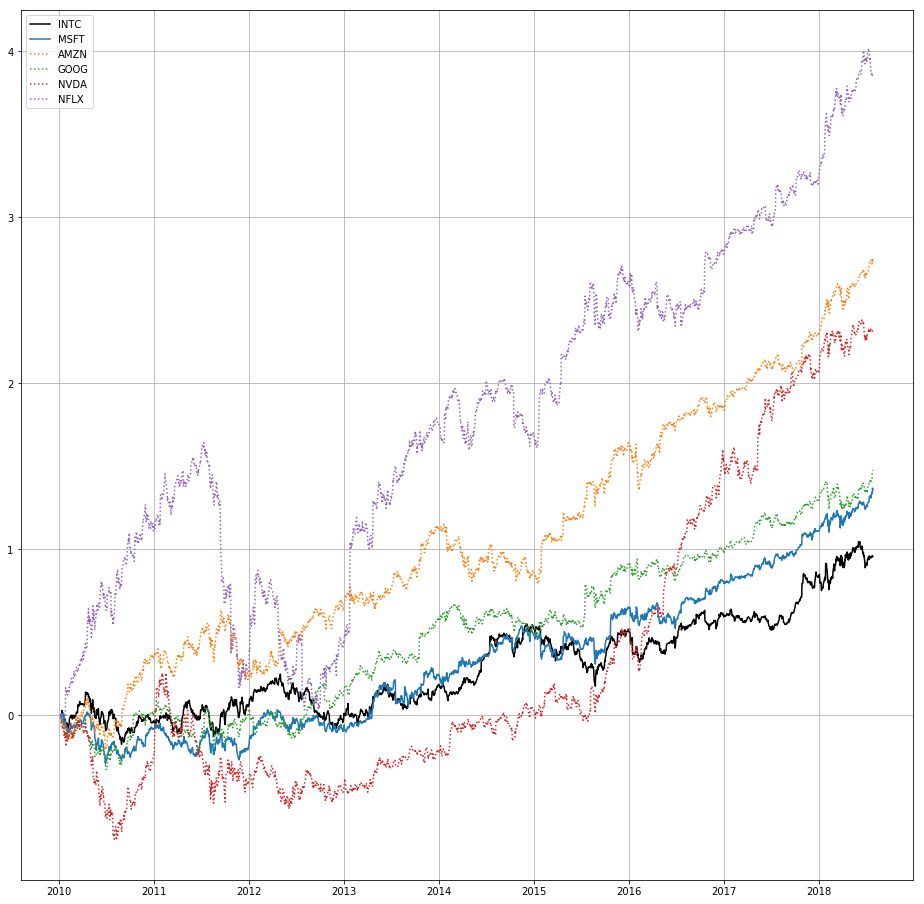

In [67]:
# Plot intel log returns to other 
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['AMZN_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['GOOG_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NFLX_logReturns']]),linestyle =':')
plt.legend(['INTC','MSFT','AMZN','GOOG','NVDA','NFLX','FB'], loc='upper left')
plt.grid(True)
plt.show()

In [68]:
df_corr = train_data[['Close_logReturns','MSFT_logReturns','AMZN_logReturns','GOOG_logReturns','NVDA_logReturns',
                       'NFLX_logReturns']]

,Close_logReturns,MSFT_logReturns,AMZN_logReturns,GOOG_logReturns,NVDA_logReturns,NFLX_logReturns
Close_logReturns,1.000000,0.563409,0.343248,0.394103,0.477909,0.203499
MSFT_logReturns,0.563409,1.000000,0.432333,0.507588,0.445656,0.222210
AMZN_logReturns,0.343248,0.432333,1.000000,0.527471,0.340352,0.359644
GOOG_logReturns,0.394103,0.507588,0.527471,1.000000,0.407462,0.284023
NVDA_logReturns,0.477909,0.445656,0.340352,0.407462,1.000000,0.254649
NFLX_logReturns,0.203499,0.222210,0.359644,0.284023,0.254649,1.000000


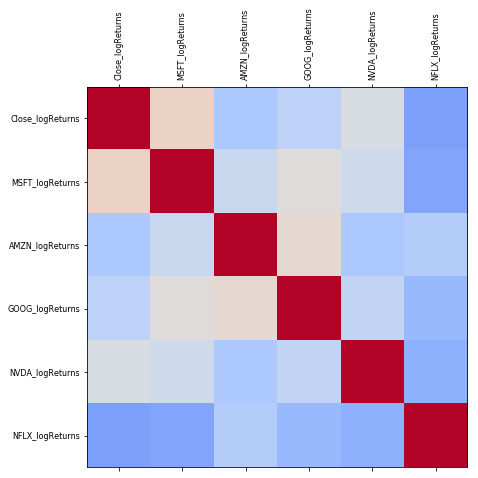

In [69]:
df = df_corr.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

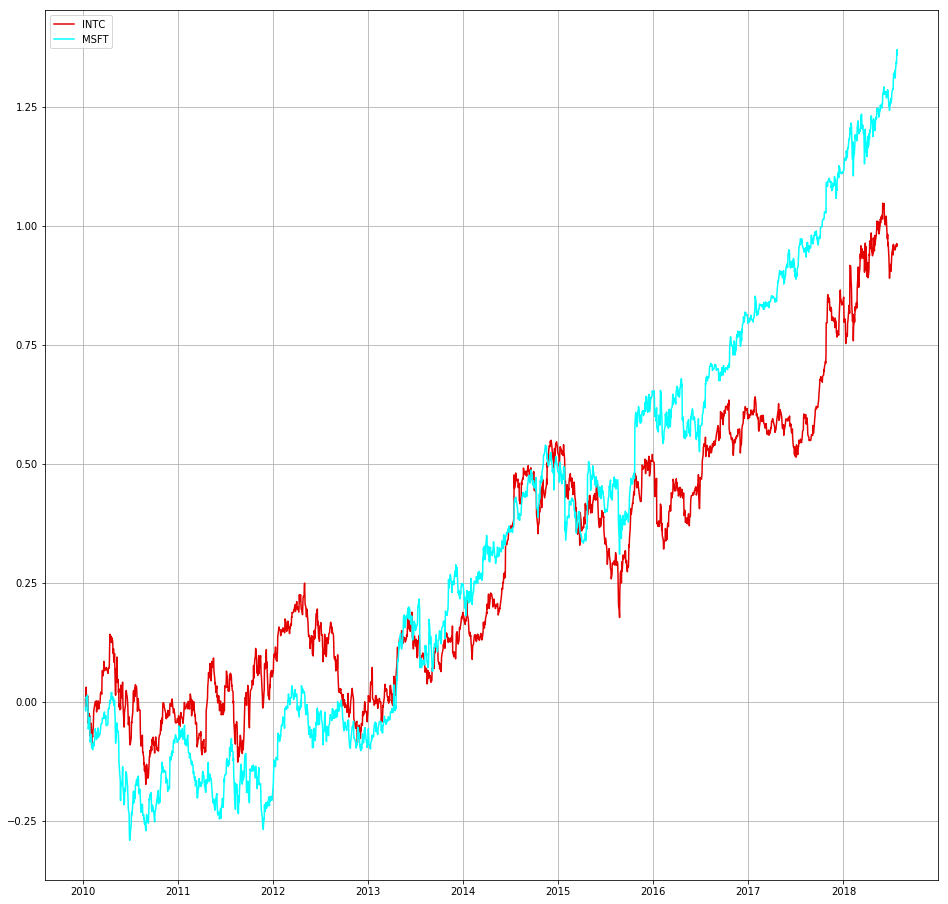

In [70]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','MSFT'], loc='upper left')

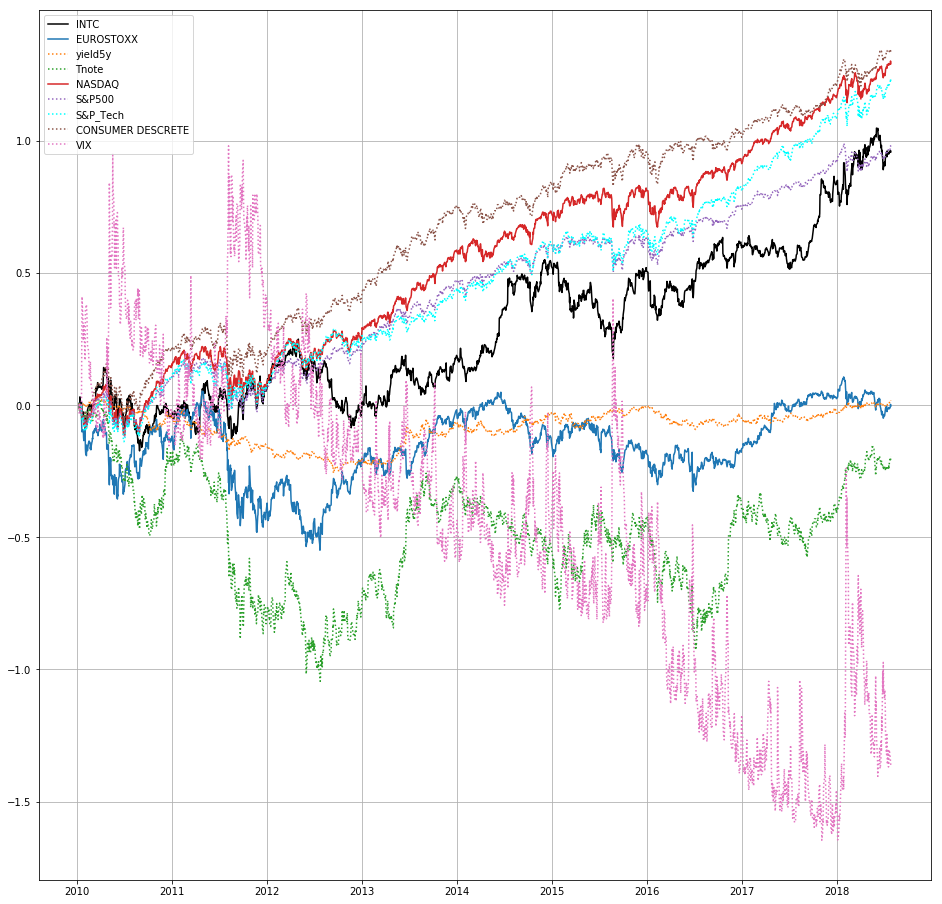

In [71]:
# Plot intel log returns to macro
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['EUROSTOXX50_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['yield_5y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['Tnote_10y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP500_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.plot(np.cumsum(train_data[['CONS_DESCRETE_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),linestyle =':')
plt.legend(['INTC','EUROSTOXX','yield5y','Tnote','NASDAQ','S&P500','S&P_Tech','CONSUMER DESCRETE','VIX'], loc='upper left')
plt.grid(True)
plt.show()

In [72]:
df_corr2 = train_data[['Close_logReturns','EUROSTOXX50_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','NASDAQ_COMP_logReturns',
                       'SNP500_logReturns','SNP_TECH_logReturns','CONS_DESCRETE_logReturns','VIX_logReturns']]

,Close_logReturns,EUROSTOXX50_logReturns,yield_5y_logReturns,Tnote_10y_logReturns,NASDAQ_COMP_logReturns,SNP500_logReturns,SNP_TECH_logReturns,CONS_DESCRETE_logReturns,VIX_logReturns
Close_logReturns,1.000000,0.529317,0.092134,0.271336,0.664044,0.649890,0.695510,0.588302,-0.518421
EUROSTOXX50_logReturns,0.529317,1.000000,0.084569,0.439372,0.761379,0.823661,0.739960,0.747451,-0.662365
yield_5y_logReturns,0.092134,0.084569,1.000000,0.554224,0.115319,0.115387,0.114423,0.122988,-0.102945
Tnote_10y_logReturns,0.271336,0.439372,0.554224,1.000000,0.424395,0.455368,0.393843,0.428554,-0.355501
NASDAQ_COMP_logReturns,0.664044,0.761379,0.115319,0.424395,1.000000,0.952983,0.958857,0.915047,-0.777773
SNP500_logReturns,0.649890,0.823661,0.115387,0.455368,0.952983,1.000000,0.919602,0.924334,-0.805449
SNP_TECH_logReturns,0.695510,0.739960,0.114423,0.393843,0.958857,0.919602,1.000000,0.856093,-0.752235
CONS_DESCRETE_logReturns,0.588302,0.747451,0.122988,0.428554,0.915047,0.924334,0.856093,1.000000,-0.750226
VIX_logReturns,-0.518421,-0.662365,-0.102945,-0.355501,-0.777773,-0.805449,-0.752235,-0.750226,1.000000


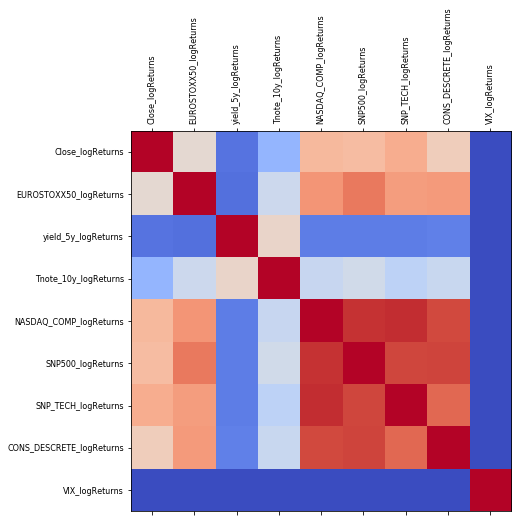

In [73]:
df = df_corr2.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sign
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sign
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sign
  


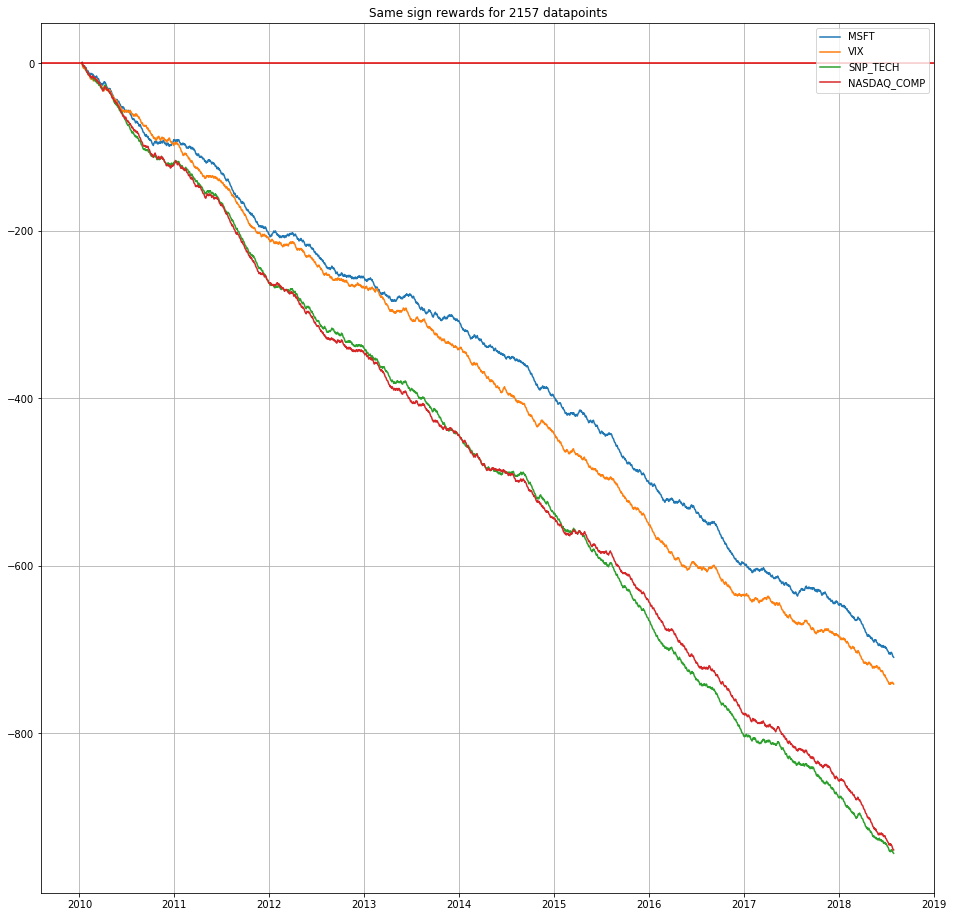

In [74]:
# MSFT same sign
diff_sign = np.sign(result['Close_logReturns']) != np.sign(result['MSFT_logReturns'])
diff_sign = diff_sign.replace(True,1).replace(False,-1)

# VIX opposite sign
diff_sign_vix = np.sign(result['Close_logReturns']) != np.sign(result['VIX_logReturns'])
diff_sign_vix = diff_sign_vix.replace(True,-1).replace(False,1)

# SNP Tech same sign
diff_sign_spt = np.sign(result['Close_logReturns']) != np.sign(result['SNP_TECH_logReturns'])
diff_sign_spt = diff_sign_spt.replace(True,1).replace(False,-1)

# Nasdaq Composite same sign
diff_sign_ndc = np.sign(result['Close_logReturns']) != np.sign(result['NASDAQ_COMP_logReturns'])
diff_sign_ndc = diff_sign_ndc.replace(True,1).replace(False,-1)

plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(diff_sign))
plt.plot(np.cumsum(diff_sign_vix))
plt.plot(np.cumsum(diff_sign_spt))
plt.plot(np.cumsum(diff_sign_ndc))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.legend(['MSFT','VIX','SNP_TECH','NASDAQ_COMP'], loc='upper right')
plt.grid(True)
plt.title("Same sign rewards for " + str(len(diff_sign)) +" datapoints")
plt.show()

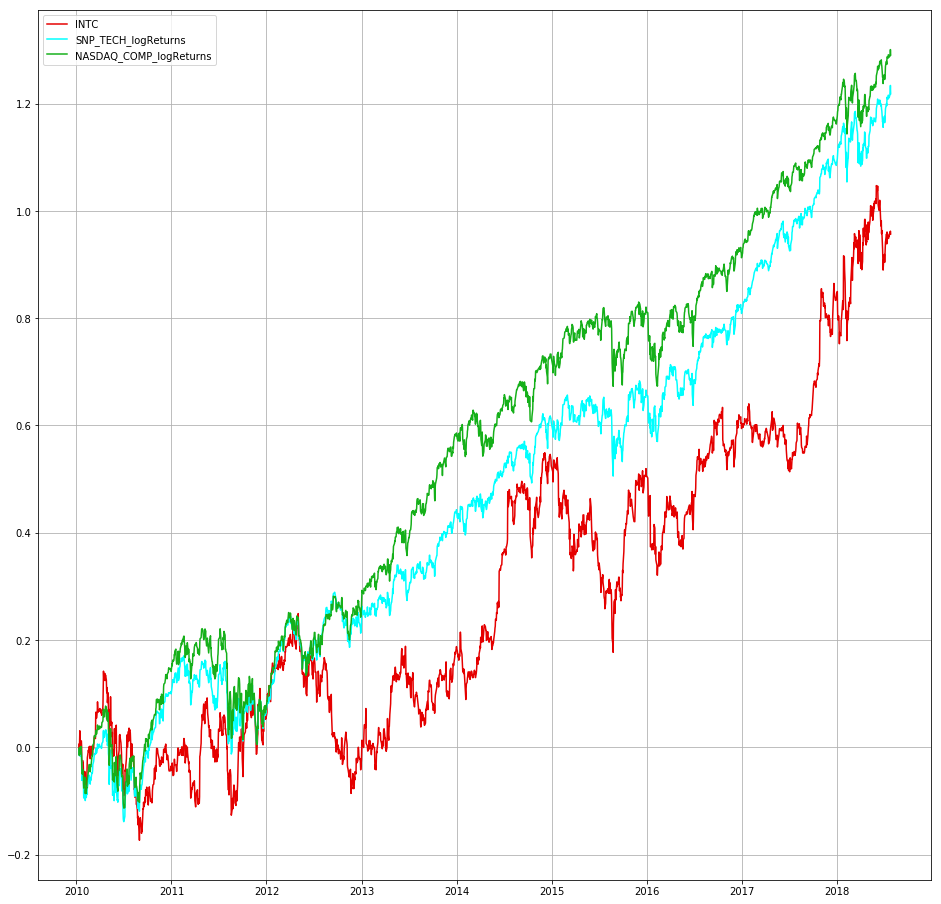

In [75]:
# Plot cumsum of returns Close,SNP_Tech, Nasdaq Comp
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),color='xkcd:green',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','SNP_TECH_logReturns','NASDAQ_COMP_logReturns'], loc='upper left')

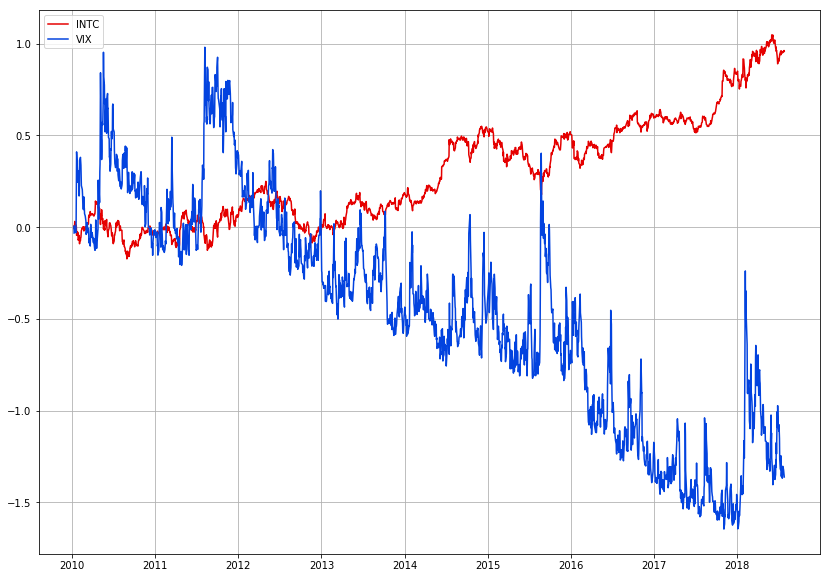

In [76]:
#Plot Cumsum close and vix
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),color='xkcd:blue',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','VIX'], loc='upper left')

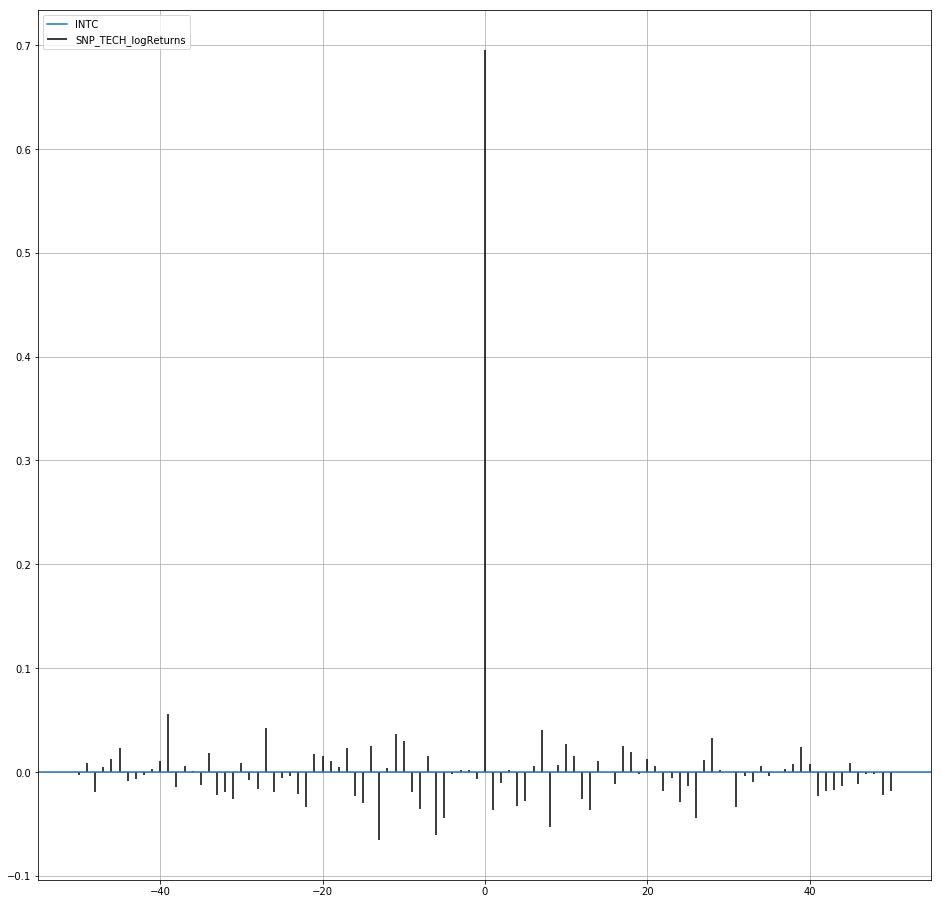

In [77]:
# show lagged cross correlation between intc and highest corr coeff
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['SNP_TECH_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','SNP_TECH_logReturns'], loc='upper left')
plt.show()

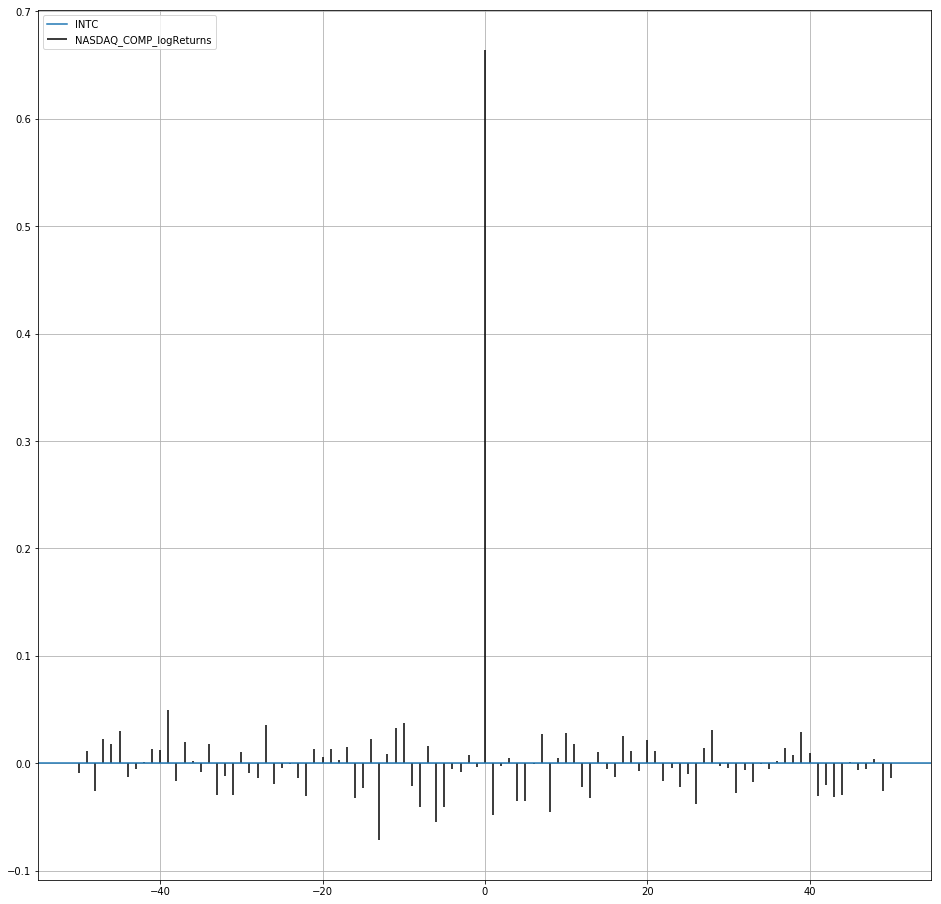

In [78]:
# show lagged cross correlation with NASDAQ_COMP
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['NASDAQ_COMP_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','NASDAQ_COMP_logReturns'], loc='upper left')
plt.show()

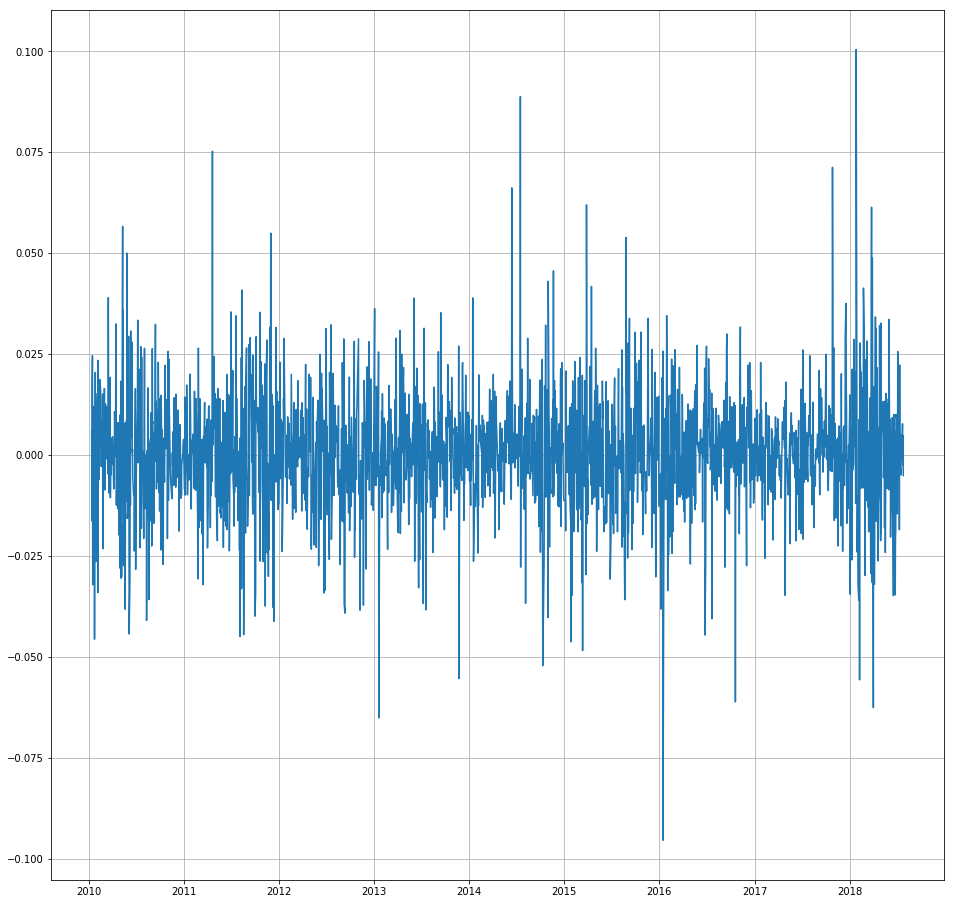

In [79]:
# Show distribution of log returns of INTC
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['Close_logReturns']])
plt.grid(True)

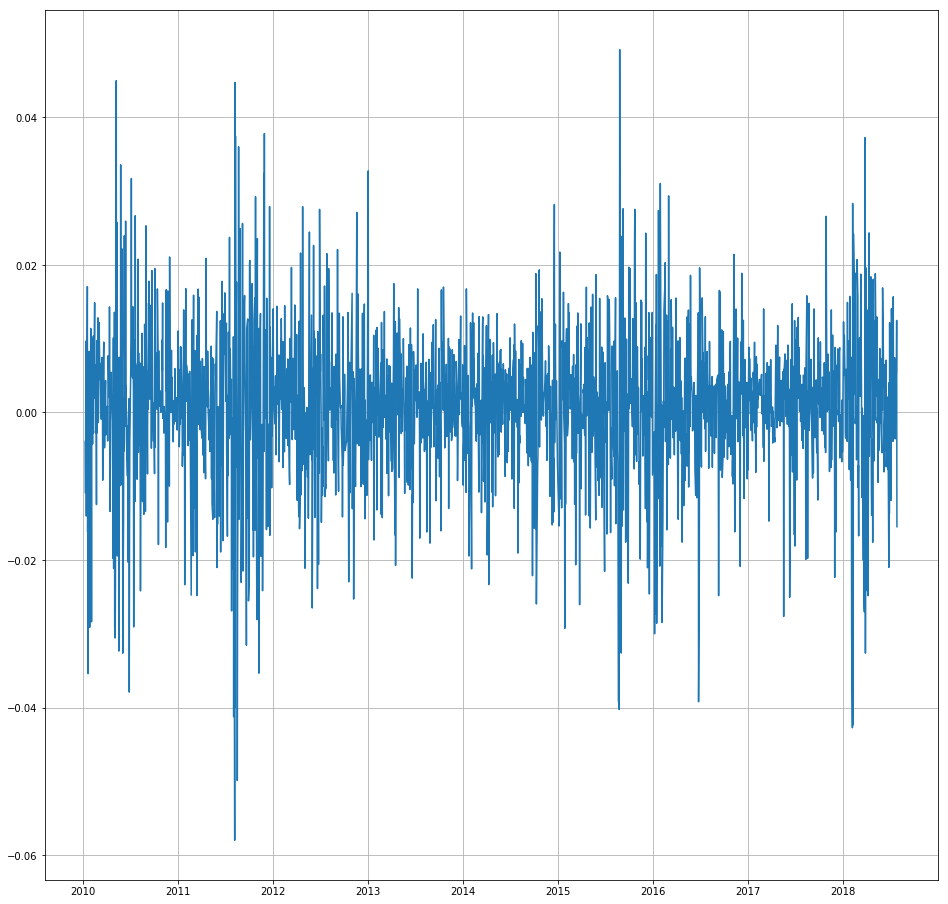

In [80]:
# Show distribution of log returns of SNP Tech
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['SNP_TECH_logReturns']])
plt.grid(True)

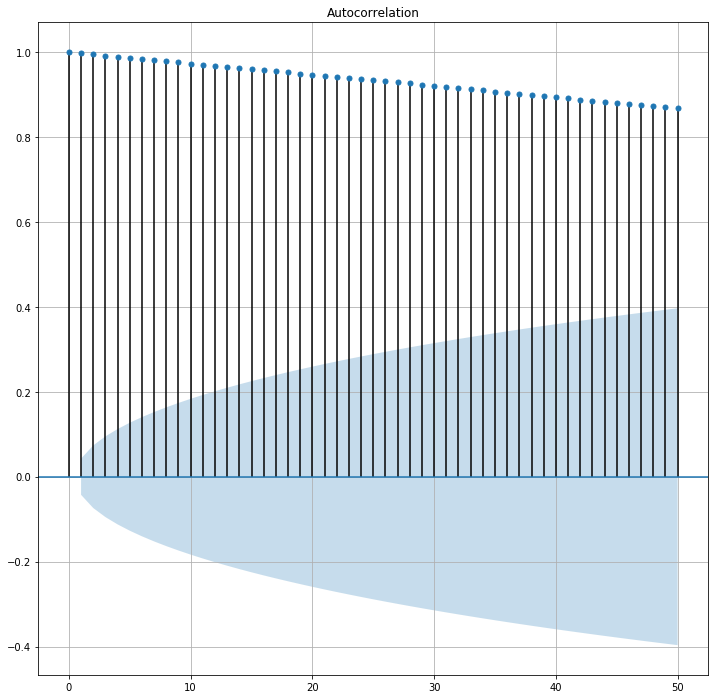

In [81]:
# plot auto correlation with itself
from statsmodels.graphics.tsaplots import plot_acf
intc_arr = np.array(np.cumsum(train_data[['Close_logReturns']]))
intc_arr = intc_arr.ravel()
series = intc_arr
plt.rc("figure",figsize=(12,12))
plot_acf(series, lags=50,use_vlines=True)
plt.grid(True)

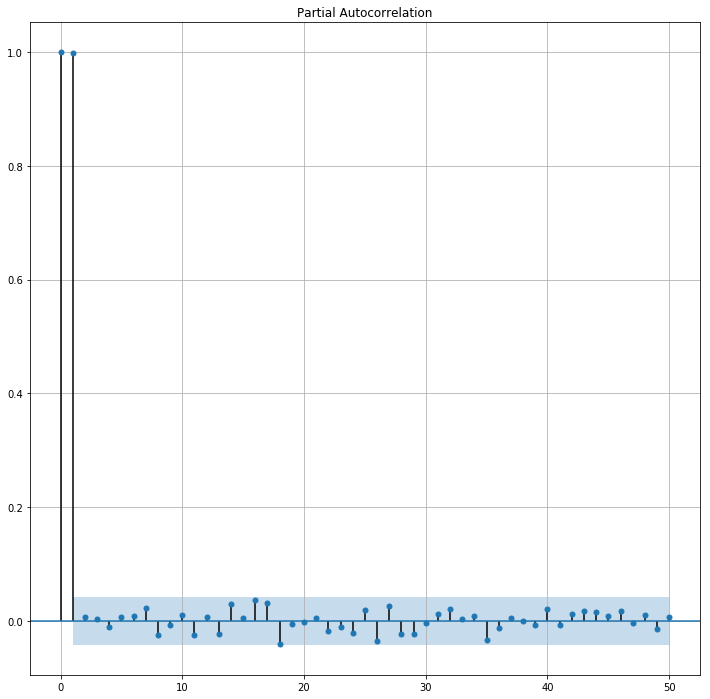

In [83]:
# plot partial auto correlation of INTC
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure",figsize=(12,12))
plot_pacf(series, lags=50,use_vlines=True)
plt.grid(True)

In [84]:
# clip data and cut extremes
train_data['Close_logReturnsClipped'] = train_data['Close_logReturns'].clip(-0.05,0.05)

In [159]:
train_data_final = train_data.drop(['High_logReturns','Low_logReturns','Close_logReturns','AMZN_logReturns','NVDA_logReturns',
                             'GOOG_logReturns','NFLX_logReturns','EUROSTOXX50_logReturns',
                             'SNP500_logReturns','CONS_DESCRETE_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','VIX'
                             ], axis=1)
# Shift to 1 period to predict next period
predict_step = 1
y = train_data_final.shift(periods=predict_step)
y =  y['Close_logReturnsClipped']
y.fillna(0, inplace=True)

train_data_final = train_data_final.drop(['Close_logReturnsClipped'], axis=1)

# Train and test on ExtraTrees
X_train, X_test, y_train, y_test = ms.train_test_split(train_data_final, y, test_size=0.3)

In [163]:

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *

# Fit estimators
model_et  = ExtraTreesRegressor()

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 7, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(
    estimator = model_et, 
    param_distributions = random_grid, 
    n_iter = 100, 
    cv = 5, 
    verbose=1, 
    random_state=42, 
    n_jobs = -1)

rf_random.fit(X_train, y_train)

print ("Coefficient of determination on training set: (R^2)",rf_random.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(rf_random, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))
    
predicted_values = rf_random.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.4min finished


Coefficient of determination on training set: (R^2) 0.28550893496250596
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.5min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.2min finished


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.3min finished


Average coefficient of determination using 5-fold crossvalidation: -0.015159167173125288


In [173]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'max_features': 'log2',
 'max_depth': 10,
 'bootstrap': False}

Feature ranking:
1. feature 9 - KF_mean (0.077362)
2. feature 19 - Weekday (0.071934)
3. feature 15 - Daymonth (0.055619)
4. feature 8 - Month (0.054752)
5. feature 18 - Weakyear (0.050901)
6. feature 10 - MSFT_logReturns (0.046981)
7. feature 5 - SNP_TECH_logReturns (0.043773)
8. feature 12 - NASDAQ_COMP_logReturns (0.043734)
9. feature 6 - VIX_logReturns (0.043160)
10. feature 16 - TradingRange (0.042704)
11. feature 1 - OBV (0.039717)
12. feature 23 - TSI (0.039435)
13. feature 7 - ATR (0.037349)
14. feature 17 - HighestHigh (0.033842)
15. feature 2 - LowestLow (0.033420)
16. feature 11 - Volume_Scaled (0.033255)
17. feature 24 - ATR_Scaled (0.033162)
18. feature 0 - TSI_Scaled (0.030198)
19. feature 4 - OBV_Scaled (0.028524)
20. feature 20 - TradingRange_Scaled (0.027094)
21. feature 13 - HighestHigh_Scaled (0.026947)
22. feature 22 - LowestLow_Scaled (0.026803)
23. feature 3 - KFMean_Scaled (0.026616)
24. feature 14 - support_distance_Scaled (0.026609)
25. feature 21 - resistance_

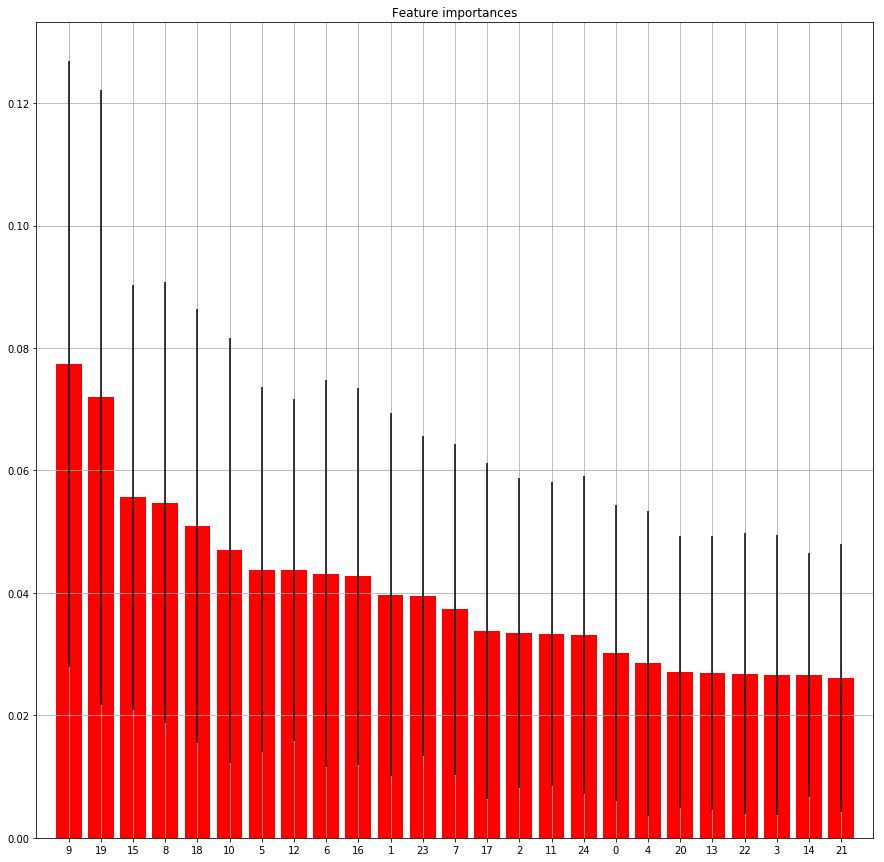

In [176]:
# Show importance of features
importances = rf_random.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_random.best_estimator_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f],X_train.columns[f], importances[indices[f]]))
    
    
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.grid(True)
plt.show()


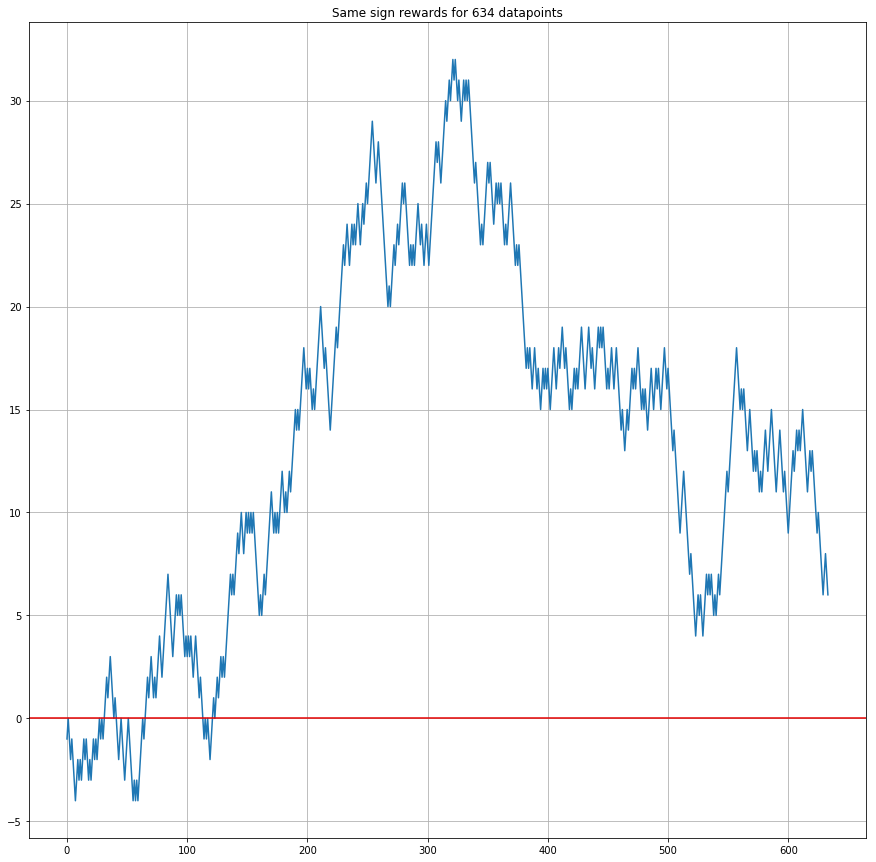

In [153]:
sign = [] 
for i in range(len(actual_and_test)):         
    if np.sign(actual_and_test[i,0]) == np.sign(actual_and_test[i,1]):
        sign.append(1)
    else:
        sign.append(-1)
res = np.column_stack([actual_and_test,sign])
plt.plot(np.cumsum(sign))
plt.axhline(y=0,color='xkcd:red',linestyle ='-')
plt.title("Same sign rewards for " + str(len(sign)) +" datapoints")
plt.grid(True)

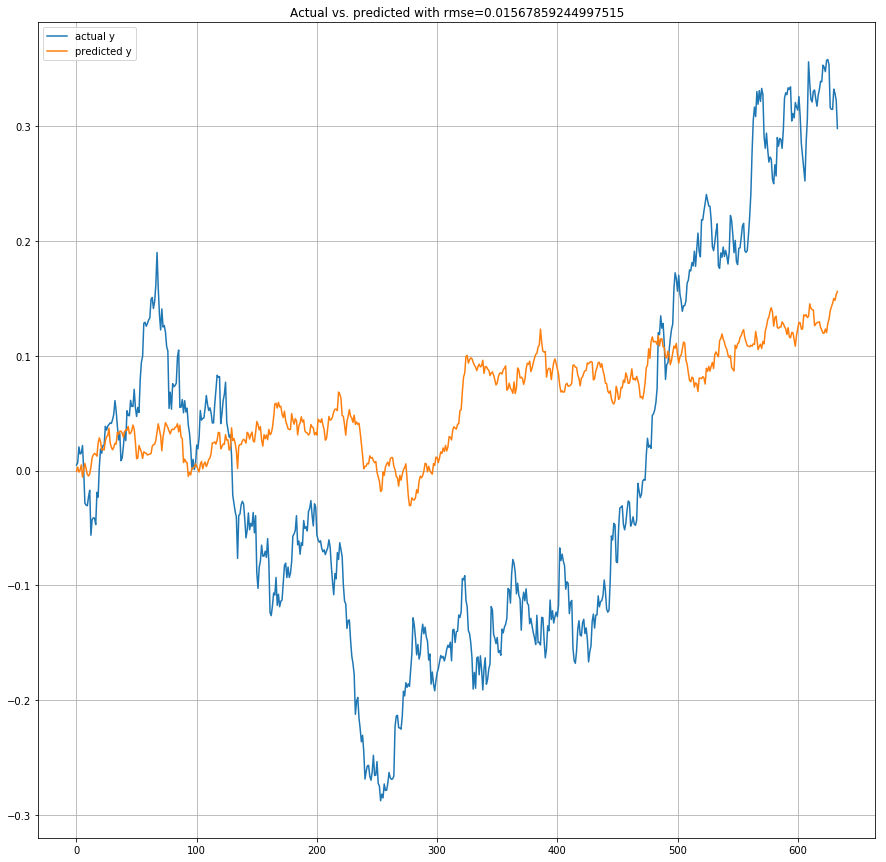

In [157]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(actual_and_test[:,0], actual_and_test[:,1]))

plt.title("Actual vs. predicted with rmse=" + str(rms))
plt.rc("figure",figsize=(15,15))
plt.plot(np.cumsum(actual_and_test[:,0]))
plt.plot(np.cumsum(actual_and_test[:,1]))
plt.legend(['actual y', 'predicted y'])
plt.grid(True)